In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score


# from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.utils import to_categorical

2023-01-17 09:55:13.389014: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
train_dir = "/Users/harry.lopez/Documents/Dataset/archive/Train"
test_dir = "/Users/harry.lopez/Documents/Dataset/archive/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 46      #Was 46
EPOCHS = 5
LR =  0.00003
NUM_CLASSES = 14
CLASS_LABELS = ['Abuse','Arrest','Arson','Assault','Burglary','Explosion','Fighting',"Normal",'RoadAccidents','Robbery','Shooting','Shoplifting','Stealing','Vandalism']

In [3]:
preprocess_fun = tf.keras.applications.densenet.preprocess_input

train_datagen = ImageDataGenerator(
                                   #horizontal_flip=True,
                                   #width_shift_range=0.1,
                                   #height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split=0.2, # set validation split, Added
                                   preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  preprocessing_function=preprocess_fun
                                 )

In [4]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                     subset='training',    #Added
                                                    seed = SEED
                                                   )

validation_generator = train_datagen.flow_from_directory(train_dir, # same directory as training data
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset='validation', # set as validation data,  #Added
                                                    seed = SEED
                                                   )
  




test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = SEED
                                                  )

Found 1013081 images belonging to 14 classes.
Found 253264 images belonging to 14 classes.
Found 111308 images belonging to 14 classes.


In [8]:
model = Sequential()

# 2 sets of CRP (Convolution, RELU, Pooling)
model.add(Conv2D(6, (5, 5),
                 padding = "same", # to set padding at 0, use "valid"
                 input_shape=(IMG_HEIGHT ,IMG_WIDTH,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(16, (5, 5),
                 padding = "same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model.add(Conv2D(120, (5, 5),
                 padding = "same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

# Fully connected layers (w/ RELU)
model.add(Flatten())
model.add(Dense(120))
model.add(Activation("relu"))

model.add(Dense(84))
model.add(Activation("relu"))
# Softmax (for classification)
model.add(Dense(NUM_CLASSES))
model.add(Activation("softmax"))
           
model.compile(optimizer=tf.keras.optimizers.SGD(LR), 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.TrueNegatives(),tf.keras.metrics.TruePositives()])
    
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 6)         456       
                                                                 
 activation_5 (Activation)   (None, 64, 64, 6)         0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 6)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 16)        2416      
                                                                 
 activation_6 (Activation)   (None, 32, 32, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                  

In [17]:
history = model.fit(x = train_generator,validation_data=validation_generator,epochs = EPOCHS)

Epoch 1/5
22024/22024 [==============================] - 1966s 89ms/step - loss: 1.1875 - auc: 0.8937 - true_negatives: 12915187.0000 - true_positives: 758215.0000 - val_loss: 1.1853 - val_auc: 0.8956 - val_true_negatives: 3228721.0000 - val_true_positives: 189553.0000
Epoch 2/5
22024/22024 [==============================] - 2082s 95ms/step - loss: 1.1844 - auc: 0.8957 - true_negatives: 12915187.0000 - true_positives: 758215.0000 - val_loss: 1.1835 - val_auc: 0.8950 - val_true_negatives: 3228721.0000 - val_true_positives: 189553.0000
Epoch 3/5
22024/22024 [==============================] - 2105s 96ms/step - loss: 1.1832 - auc: 0.8957 - true_negatives: 12915187.0000 - true_positives: 758215.0000 - val_loss: 1.1827 - val_auc: 0.8976 - val_true_negatives: 3228721.0000 - val_true_positives: 189553.0000
Epoch 4/5
22024/22024 [==============================] - 2024s 92ms/step - loss: 1.1826 - auc: 0.8956 - true_negatives: 12915187.0000 - true_positives: 758215.0000 - val_loss: 1.1824 - val_a

2420/2420 [==============================] - 80s 33ms/step
ROC AUC score: 0.7666187507079564


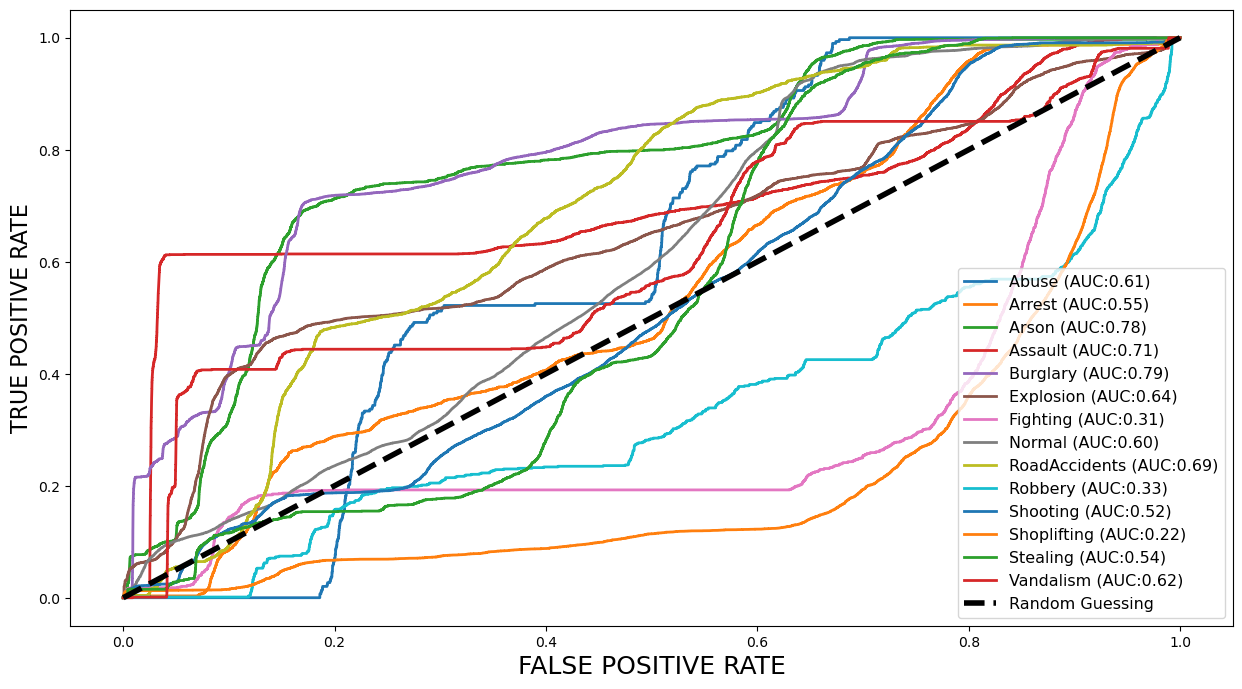

In [20]:
preds = model.predict(test_generator)
y_test = test_generator.classes
fig, c_ax = plt.subplots(1,1, figsize = (15,8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(y_test , preds  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [19]:
model.save('/Users/harry.lopez/Documents/Python/Models/Test.Lenet.2.h5')